# Computing Hake NASC from Ship Echosounder Data

Jupyter notebook accompanying the manuscript:

_Echopype: Interoperable and scalable echosounder data processing with Echopype_  
_Authors: Wu-Jung Lee, Landung Setiawan, Caesar Tuguinay, Emilio Mayorga, and Valentina Staneva_

## Introduction

### Description

This notebook uses a small subset of the EK60 echosounder data collected during the [2017 Joint U.S.-Canada Integrated Ecosystem and Pacific Hake Acoustic Trawl Survey (aka the "Hake survey")](https://www.fisheries.noaa.gov/west-coast/science-data/joint-us-canada-integrated-ecosystem-and-pacific-hake-acoustic-trawl-survey) to illustrate a processing pipeline that compute Nautical Areal Scattering Coefficient (NASC) attributed to Pacific hake. The workflow includes steps to perform data conversion, calibration, regridding, and masking, using functions from [`Echopype`](https://echopype.readthedocs.io), and core scientific Python software packages, particularly `NumPy`, `Xarray`, and `Dask`. This workflow utilizes hake annotations which were manually produced from the NOAA Fisheries Northwest Fisheries Science Center (NWFSC) [Fisheries Engineering and Acoustic Technologies Team (FEAT)](https://www.fisheries.noaa.gov/west-coast/sustainable-fisheries/fisheries-engineering-and-acoustic-technologies-team).

### Outline

1) [Convert EK60 `.raw` files to `EchoData` Objects](###Convert-EK60-.raw-files-to-EchoData-Objects)
2) [Combine EchoData Objects](###Combine-EchoData-Objects)
3) [Calibrate raw backscatter measurement in the combined EchoData object to Sv](###Calibrate-raw-backscatter-measurement-in-the-combined-EchoData-object-to-Sv)
4) [Read and Apply a Binary Mask for Pacific Hake Presence](###Read-and-Apply-a-Binary-Mask-for-Pacific-Hake-Presence)
5) [Compute and Plot NASC Attributed to Pacific Hake](###Compute-and-Plot-NASC-Attributed-to-Pacific-Hake)

### Running the notebook

This notebook can be run with a conda environment created using the [conda environment file](../conda/environment-ep-main.yml). The notebook creates a directory, if not already present: `./exports/hake_NASC`. All Zarr files will be exported there.

### Note
We encourage importing `echopype` as `ep` for consistency.

In [1]:
from pathlib import Path
import os

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client

import echopype as ep
from echopype import colormap # needed for the EK500 colormap

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
# Ignore large graph dask UserWarnings
warnings.simplefilter("ignore", category=UserWarning)

## Setup

### Path setup
Set paths and create directories to store Zarr files:

In [2]:
import_path = Path("example_data/NWFSC_2017_hake_survey_transect_with_hake/")

output_path = Path("./exports/hake_NASC")
output_path.mkdir(exist_ok=True, parents=True)

echodata_zarr_path = output_path / "echodata_zarr"
echodata_zarr_path.mkdir(exist_ok=True)
combined_zarr_path = output_path / "combined_zarr"
combined_zarr_path.mkdir(exist_ok=True)

### Dask Client setup

Echopype leverages Dask's lazy-load mechanisms to perform out-of-core and parallelized computation on large datasets. We use the Dask `Client` that is pointed to a `Scheduler` that schedules tasks and allocate memory for these computations.

In [3]:
# Use maximum number of CPUs for Dask Client
client = Client(n_workers=os.cpu_count())
print("Dash Client Dashboard:", client.dashboard_link)

Dash Client Dashboard: http://127.0.0.1:8787/status


Click on the Dask Client Dashboard link above to view the computations live.

For more information on how to use, view, and interpret the Dashboard, go to this link: https://docs.dask.org/en/stable/dashboard.html

## Data processing workflow - Echopype

The following data processing steps follow the typical Echopype workflow, which converts and standardizes data before performing more computation. Below we first convert and save the `.raw` files generated by EK60 to Zarr stores on disk, and lazy-load them back for downstream processing. This allows us to perform computations that may require resources that are larger than the local system memory.

### Identify target echosounder data files

Identify EK60 `.raw` files associated with the first segment of transect 45 of the 2017 survey:

In [4]:
ncei_2017_ek60_raws_path = "ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60"
transect_name = "x0045_0_wt_20170717_213507_f0010"
transect_file_paths = []
with open(import_path / transect_name, 'r') as file:
    for line in file:
        transect_file_paths.append(
            f"{ncei_2017_ek60_raws_path}/{line.strip()}.raw"
        )

In [5]:
transect_file_paths

['ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T212115.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T214833.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T221909.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T224632.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T231028.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T233247.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170717-T235306.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T001206.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T003054.raw',
 'ncei-wcsd-archive/data/raw/Bell_M._Shimada/SH1707/EK60/Summer2017-D20170718-T004846.raw']

These RAW files combined are about ~250 MB in size.

### Convert EK60 `.raw` Files to EchoData Objects

In [6]:
%%time

# Save Echodata objects locally
def open_and_save(raw_file, sonar_model, use_swap, save_path, storage_options):
    try:
        ed = ep.open_raw(
            raw_file=f's3://{raw_file}',
            sonar_model=sonar_model,
            use_swap=use_swap,
            storage_options=storage_options,
        )
        ed.to_zarr(save_path, overwrite=True, compute=True)
    except Exception as e:
        print("Error with Exception: ", e)

# Parse EK60 `.RAW` file and save to Zarr Store
open_and_save_futures = []
for raw_file_url in transect_file_paths:
    open_and_save_future = client.submit(
        open_and_save,
        raw_file=raw_file_url,
        sonar_model='ek60',
        use_swap=True,
        save_path=echodata_zarr_path,
        storage_options={'anon': True}
    )
    open_and_save_futures.append(open_and_save_future)
open_and_save_futures = client.gather(open_and_save_futures)

CPU times: user 956 ms, sys: 229 ms, total: 1.18 s
Wall time: 10.3 s


###  Combine Echodata Objects

Under the hood of the `ep.combine_echodata` function, the Zarr stores of each EchoData object are loaded and appended lazily, meaning that no data loading or appending actually happens until the combined object is saved to disk via `to_zarr`. Since the EchoData is appended sequentially based on the data time sequence and therefore not parallelized, this is the slowest stage of the processing pipeline.

In [7]:
%%time

# Open (lazy-load) Zarr stores containing EchoData Objects, and lazily combine them
ed_future_list = []
for converted_file in sorted(echodata_zarr_path.glob("*.zarr")):
    ed_future = client.submit(    
        ep.open_converted,
        converted_raw_path=converted_file,
        chunks={}
    )
    ed_future_list.append(ed_future)
ed_list = client.gather(ed_future_list)
ed_combined = ep.combine_echodata(ed_list)

# Save the combined EchoData object to a new Zarr store
# The appending operation only happens when relevant data needs to be save to disk
ed_combined.to_zarr(
    combined_zarr_path / "ed_combined.zarr",
    overwrite=True,
    compute=True,
)

# Lazy-load the comined Zarr store
ed_combined = ep.open_converted(
    combined_zarr_path / "ed_combined.zarr",
    chunks={},
)

CPU times: user 8.4 s, sys: 795 ms, total: 9.19 s
Wall time: 14.5 s


### Calibrate raw backscatter measurement in the combined EchoData object to Sv

Compute Volume Backscattering Strength (Sv) from raw backscatter measurements stored in the converted EchoData object, and add depth and latitude/longitude to this Xarray Dataset.

In [8]:
%%time

# Chunk EchoData object ping-wise
ed_combined = ed_combined.chunk({"ping_time": 1000, "range_sample": -1})

# Compute Sv
ds_Sv = ep.calibrate.compute_Sv(ed_combined)

# Add Depth
ds_Sv = ep.consolidate.add_depth(ds_Sv, depth_offset=9.15)

# Add Latitude and Longitude
ds_Sv = ep.consolidate.add_location(ds_Sv, ed_combined)

# Save to Zarr and offload computation to disk
ds_Sv.to_zarr(
    combined_zarr_path / "ds_Sv.zarr",
    mode="w",
    compute=True,
)

# Lazy-load the Zarr store
ds_Sv = xr.open_dataset(
    combined_zarr_path / "ds_Sv.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 1.16 s, sys: 139 ms, total: 1.3 s
Wall time: 2.64 s


In [9]:
print("Sv dimensions:", ds_Sv["Sv"].dims)

Sv dimensions: ('channel', 'ping_time', 'range_sample')


In [10]:
print("Depth dimensions:", ds_Sv["depth"].dims)

Depth dimensions: ('channel', 'ping_time', 'range_sample')


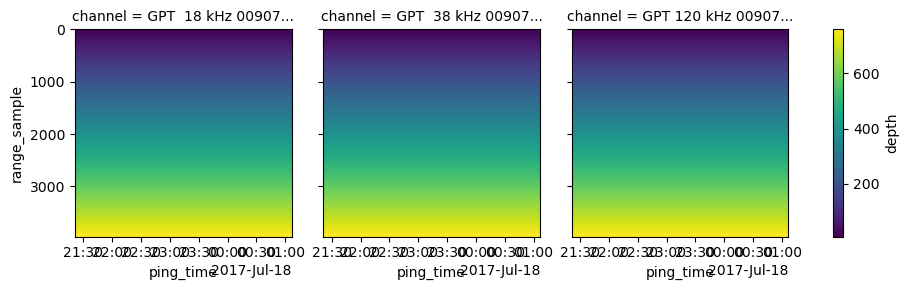

In [11]:
ds_Sv["depth"].plot(col="channel", y="range_sample", yincrease=False)

In general, hand drawn annotations for hake contain depth information that isn't aligned with the range sample dimension of the volume backscatter dataset.

To accomodate for this, we have to swap the range sample dimension with the depth dimension. Generally, this is not allowed since the depth variable is a 3D variable (with dimensions channel, range sample, and ping time) and the range sample variable is a 1D variable (with dimension range sample). However, as can be seen above, depth is equal across channel and ping time. This being the case, we can choose the depth vector corresponding to the first ping time and the first channel and set that as our new depth dimension:

In [12]:
# Create Sv dataset with depth dimension:
ds_Sv_with_depth_dim = ds_Sv.copy()
depth_1d = ds_Sv_with_depth_dim["depth"].isel(channel=0, ping_time=0)
ds_Sv_with_depth_dim["depth"] = depth_1d
ds_Sv_with_depth_dim = ds_Sv_with_depth_dim.swap_dims({"range_sample": "depth"})

### Regrid Calibrated Data

Compute mean volume backscattering strength (MVBS), which are binned averages of Sv (in the linear domain) across ping time and depth. This gets the data onto a common grid from the original ping time and depth sample size that may vary across ping and channel depending on the echosounder setting.

In [13]:
%%time

# Compute MVBS
ds_MVBS = ep.commongrid.compute_MVBS(
    ds_Sv,
    range_var="depth",
    range_bin='1m',  # in meters
    ping_time_bin='5s',  # in seconds
)

# Save to Zarr and offload computation to disk
ds_MVBS.to_zarr(
    combined_zarr_path / "ds_MVBS.zarr",
    mode="w",
    compute=True,
)

# Lazy-load the Zarr store
ds_MVBS = xr.open_dataset(
    combined_zarr_path / "ds_MVBS.zarr",
    engine="zarr",
    chunks={},
)

CPU times: user 2.64 s, sys: 249 ms, total: 2.89 s
Wall time: 11.6 s


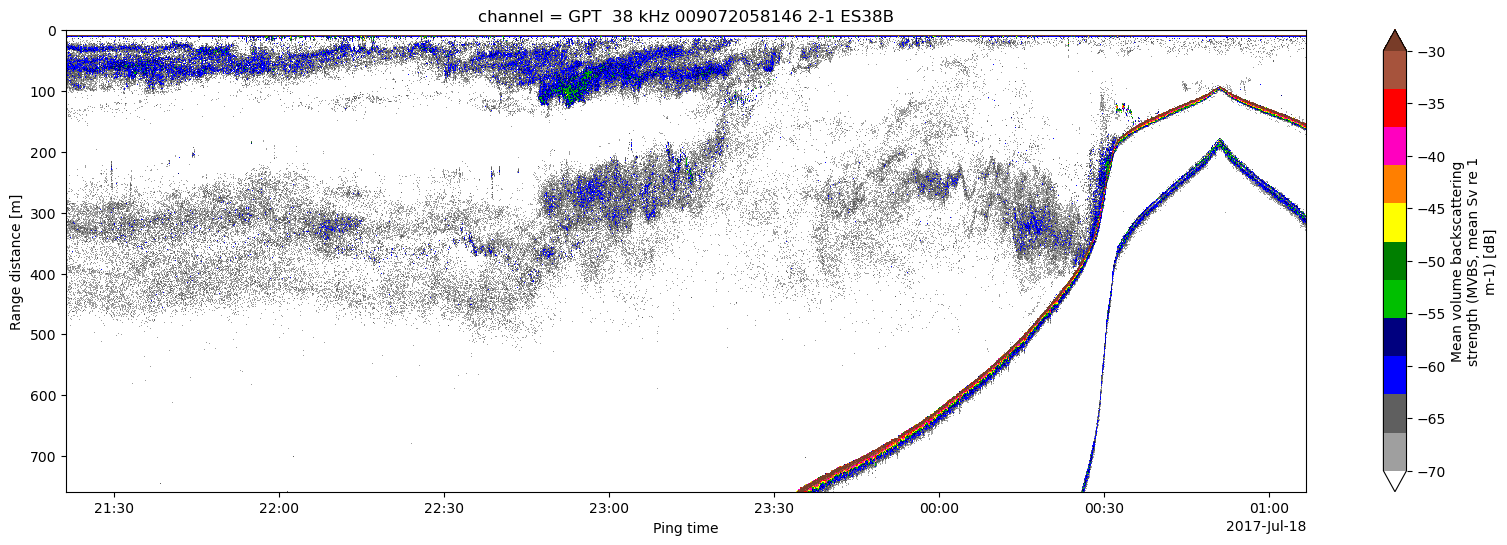

In [14]:
plt.figure(figsize = (20, 6))
# Plot MVBS from the 38kHz channel
ds_MVBS["Sv"].sel(
    channel="GPT  38 kHz 009072058146 2-1 ES38B"
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
)

### Read and Apply a Binary Mask for Pacific Hake Presence

The mask was created based on annotations by the NOAA NWFSC FEAT team, and processed with the [Echoregions](https://echoregions.readthedocs.io/en/latest/) package and stored as a boolean array. There were several steps needed to produce this mask from region annotations: excluding seafloor pixels, ensuring the regions are within transect, regridding. For more details readers can refer to Echoregions [documentation](https://echoregions.readthedocs.io/en/latest/Regions2D_functionality.html). 

In [20]:
hake_mask = xr.open_dataarray(
    "example_data/NWFSC_2017_hake_survey_transect_with_hake/hake_mask.nc",
    engine="netcdf4",
)

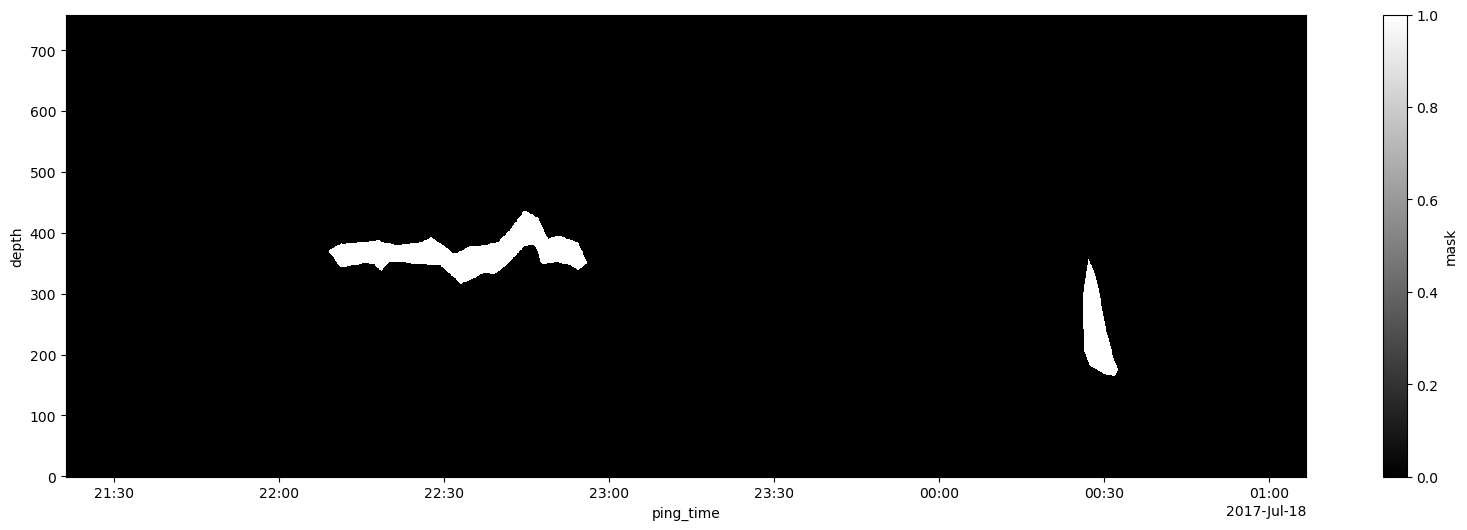

In [21]:
plt.figure(figsize = (20, 6))
hake_mask.plot(x='ping_time', y="depth", cmap='gray')

In [22]:
# Check that MVBS and regridded clean hake mask match on depth and ping time dimensions:
assert hake_mask["depth"].equals(ds_MVBS["depth"])
assert hake_mask["ping_time"].equals(ds_MVBS["ping_time"])

In this case the coordinates of the mask and MVBS are matching. If not, one would need to align the mask with the `ep.commongrid` functions.

In [23]:
# Apply the mask to ds_MVBS
ds_MVBS_hake = ep.mask.apply_mask(ds_MVBS, hake_mask)

Let's check the 38 kHz channel of the masked MVBS dataset:

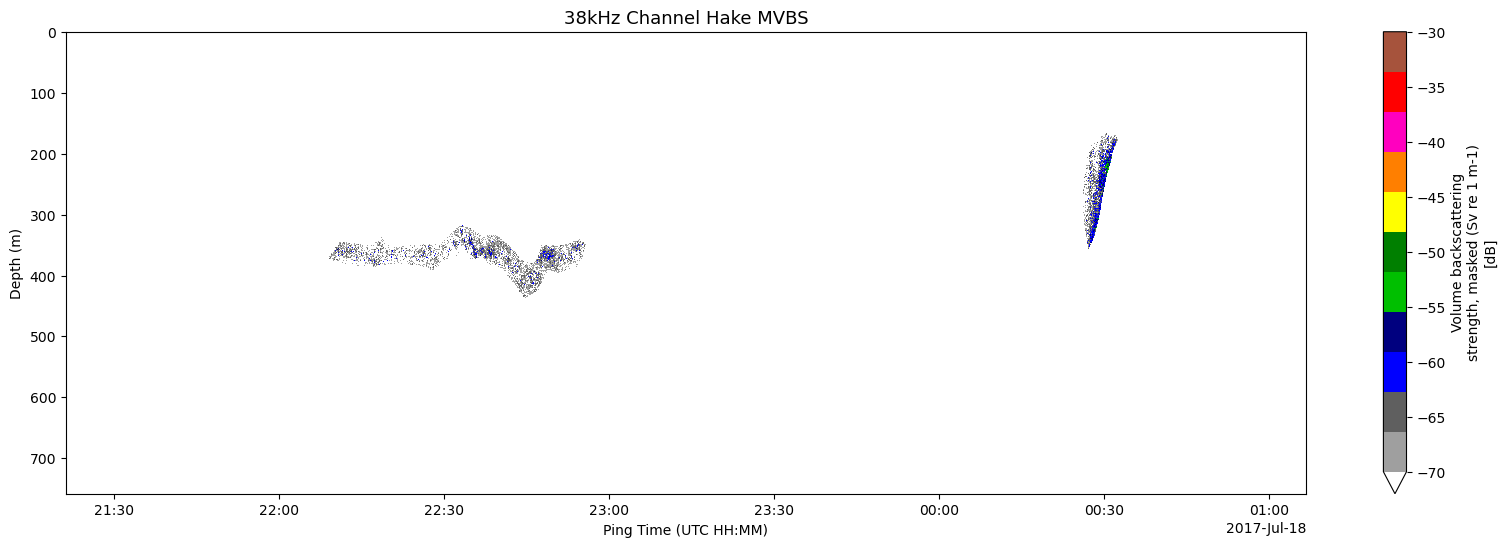

In [24]:
# Add attributes to depth and ping time
ds_MVBS_hake["depth"].attrs["long_name"] = "Depth (m)"
ds_MVBS_hake["ping_time"].attrs["long_name"] = "Ping Time (UTC HH:MM)"

# Plot 38 kHz MVBS attributed to Clean Hake
p = ds_MVBS_hake["Sv"].sel(
    channel='GPT  38 kHz 009072058146 2-1 ES38B'
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    vmin=-70,
    vmax=-30,
    cmap="ep.ek500",
    figsize=(20, 6)
)

# Set axes title
p.axes.set_title("38kHz Channel Hake MVBS", fontsize=13)

# Show plot
plt.show()

### Compute and Plot NASC Attributed to Pacific Hake

In [25]:
# Compute NASC from the masked MVBS dataset
ds_NASC = ep.commongrid.compute_NASC(
    ds_MVBS_hake,
    range_bin="10m",
    dist_bin="0.5nmi"
)

# Log-transform the NASC values for plotting
ds_NASC["NASC_log"] = 10 * np.log10(ds_NASC["NASC"])
ds_NASC["NASC_log"].attrs = {
    "long_name": "Log of NASC",
    "units": "m2 nmi-2"
}

In [26]:
# Show the hake NASC dataset
ds_NASC

<xarray.Dataset> Size: 295kB
Dimensions:            (channel: 3, distance: 80, depth: 76)
Coordinates:
  * distance           (distance) float64 640B 0.0 0.5 1.0 ... 38.5 39.0 39.5
  * channel            (channel) <U37 444B 'GPT  18 kHz 009072058c8d 1-1 ES18...
  * depth              (depth) float64 608B 0.0 10.0 20.0 ... 730.0 740.0 750.0
Data variables:
    NASC               (channel, distance, depth) float64 146kB dask.array<chunksize=(3, 80, 76), meta=np.ndarray>
    latitude           (distance) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    longitude          (distance) float64 640B dask.array<chunksize=(80,), meta=np.ndarray>
    ping_time          (distance) datetime64[ns] 640B 2017-07-17T21:23:27.500...
    frequency_nominal  (channel) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    NASC_log           (channel, distance, depth) float64 146kB dask.array<chunksize=(3, 80, 76), meta=np.ndarray>
Attributes:
    Conventions:           CF-1.7,ACDD-1.3
    time_coverage_start:   2017-07-17T21:21:15.000000000Z
    time_coverage_end:     2017-07-18T01:06:35.000000000Z
    geospatial_lat_min:    41.79633
    geospatial_lat_max:    41.82402
    geospatial_lon_min:    -125.21041
    geospatial_lon_max:    -124.41516
    processing_level:      Level 4
    processing_level_url:  https://echopype.readthedocs.io/en/stable/processi...

We plot the NASC values in log scale due to the wide range of values:

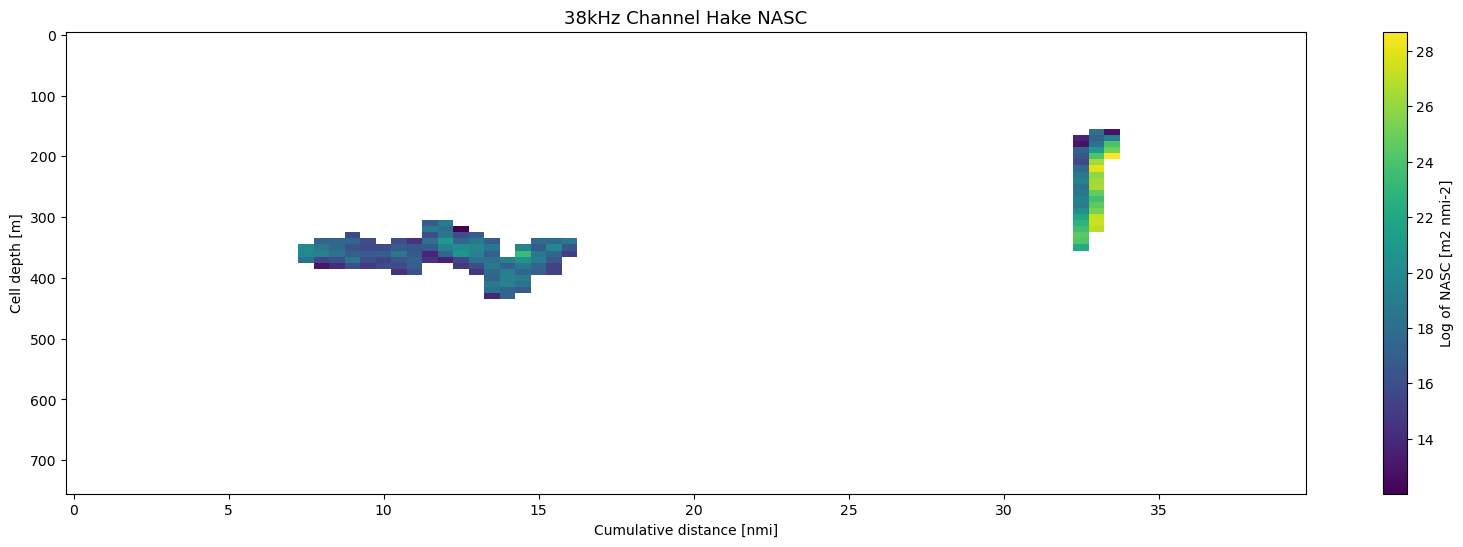

In [27]:
plt.figure(figsize = (20, 6))
# Plot 38 kHz hake NASC
p = ds_NASC["NASC_log"].sel(
    channel='GPT  38 kHz 009072058146 2-1 ES38B'
).plot.pcolormesh(
    y="depth",
    yincrease=False,
    cmap="viridis"
)

# Set axes title
p.axes.set_title("38kHz Channel Hake NASC", fontsize=13)

# Show plot
plt.show()

## Package versions

In [28]:
import datetime
import dask
print(f"echopype: {ep.__version__}, echoregions: {er.__version__}, xarray: {xr.__version__}, dask: {dask.__version__}")

print(f"\n{datetime.datetime.utcnow()} +00:00")

echopype: 0.8.5.dev82+gf9c1b27, echoregions: 0.2.2.dev2, xarray: 2024.6.0, dask: 2024.5.2

2024-08-07 15:51:12.447021 +00:00
